/Users/ed.chan/miniconda3/envs/treebeard/lib/python3.10/site-packages/earthpy/spatial.py:105: RuntimeWarning: invalid value encountered in divide
  n_diff = (b1 - b2) / (b1 + b2)


Quickshift number of segments: 5110


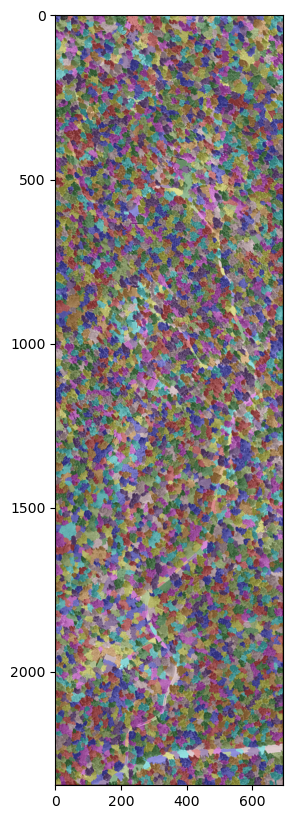

In [3]:
from skimage import io, color
from skimage.segmentation import quickshift, mark_boundaries
from rasterio.features import shapes
import numpy as np
import rasterio
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import matplotlib.pyplot as plt
from shapely.geometry import shape, Polygon
import geopandas as gpd
from rasterstats import zonal_stats
from sklearn.cluster import KMeans

tilepath = "../scratch/cropped_N4W351.tif"
tile = rasterio.open(tilepath)

red = tile.read(1).astype(float)
green = tile.read(2).astype(float)
blue = tile.read(3).astype(float)
nir = tile.read(4).astype(float)

# tile.close()

# Get image bounding box info
sr = tile.crs
bounds = tile.bounds
affine = tile.transform

#Normalized Difference Vegetation Index
ndvi = es.normalized_diff(b1=nir, b2=red)

img = io.imread(tilepath)
img = img[:, :, :3] 
segments = quickshift(img, kernel_size=3, convert2lab=False, max_dist=6, ratio=0.5).astype('int32')
print("Quickshift number of segments: %d" % len(np.unique(segments)))

# Convert to vector features
polys = []
for shp, value in shapes(segments, transform=affine):
    polys.append(shp)

# View the segments via Python
plt.figure(figsize=(10,10))
plt.imshow(color.label2rgb(segments, img, bg_label=0))

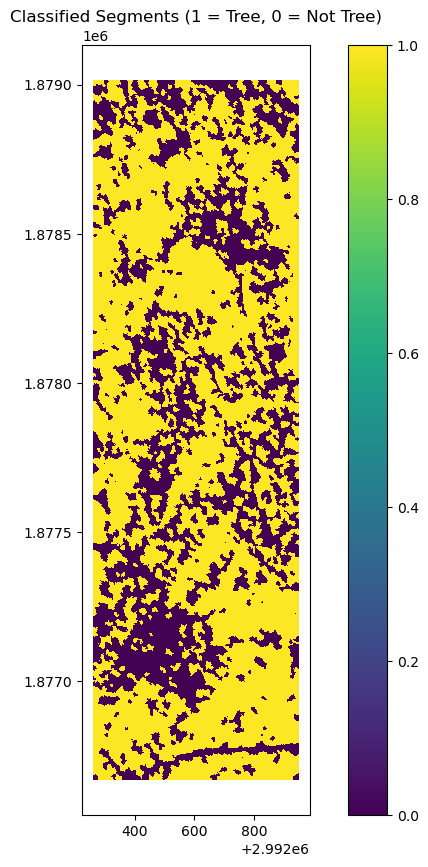

In [4]:
# Compute mean values for each band in each segment
bands = np.stack([red, green, blue, nir], axis=-1)
mean_vals = []
for shp in polys:
    mask = rasterio.features.geometry_mask([shp], transform=affine, invert=True, out_shape=bands.shape[:2])
    mean_vals.append(bands[mask].mean(axis=0))

mean_vals = np.array(mean_vals)

# Apply k-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(mean_vals)
labels = kmeans.labels_

# Create GeoDataFrame with segments and their cluster labels
geom = [shape(i) for i in polys]
gdf = gpd.GeoDataFrame({'geometry': geom, 'cluster': labels}, crs=sr)

# Assuming cluster 0 is 'not tree' and cluster 1 is 'tree' (this can vary based on the data)
# You might need to inspect the characteristics of each cluster to determine which is which
# For example, assume higher mean NIR indicates trees, you can adjust based on your data
if mean_vals[labels == 0, 3].mean() > mean_vals[labels == 1, 3].mean():
    gdf['class'] = gdf['cluster']
else:
    gdf['class'] = 1 - gdf['cluster']

# Save the classified segments to a shapefile
gdf.to_file('classified_segments.shp')

# Plot the classified segments
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='class', ax=ax, legend=True, cmap='viridis')
plt.title("Classified Segments (1 = Tree, 0 = Not Tree)")
plt.show()

In [5]:
gdf

,geometry,cluster,class
0,"POLYGON ((2992306.000 1879015.000, 2992306.000...",1,1
1,"POLYGON ((2992529.000 1879014.000, 2992529.000...",0,0
2,"POLYGON ((2992660.000 1879015.000, 2992660.000...",0,0
3,"POLYGON ((2992312.000 1879014.000, 2992312.000...",1,1
4,"POLYGON ((2992271.000 1879015.000, 2992271.000...",1,1
...,...,...,...
5819,"POLYGON ((2992513.000 1876684.000, 2992513.000...",1,1
5820,"POLYGON ((2992530.000 1876688.000, 2992530.000...",1,1
5821,"POLYGON ((2992743.000 1876686.000, 2992743.000...",1,1
5822,"POLYGON ((2992884.000 1876693.000, 2992884.000...",1,1


In [6]:
# Dissolve polygons by 'class' to merge connected polygons
dissolved = gdf.dissolve(by='class')

# Create a new GeoDataFrame with dissolved geometries
dissolved_gdf = gpd.GeoDataFrame(geometry=[dissolved.geometry.unary_union], crs=sr)
dissolved_gdf['class'] = gdf['class'].unique()

# Save the classified segments to a shapefile
dissolved_gdf.to_file('dissolved_classified_segments.shp')

# Plot the classified segments
fig, ax = plt.subplots(figsize=(10, 10))
dissolved_gdf.plot(column='class', ax=ax, legend=True, cmap='viridis')
plt.title("Classified Segments (1 = Tree, 0 = Not Tree)")
plt.show()

ValueError: Length of values (2) does not match length of index (1)

Quickshift number of segments: 5110


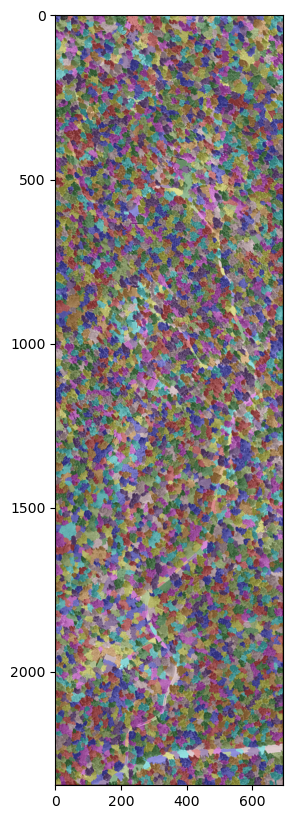

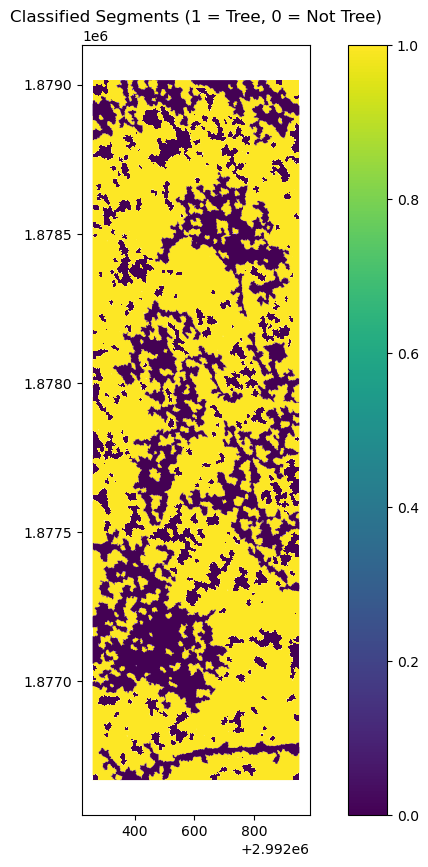

In [8]:
from skimage import io, color
from skimage.segmentation import quickshift, mark_boundaries
from rasterio.features import shapes
import numpy as np
import rasterio
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import matplotlib.pyplot as plt
from shapely.geometry import shape, Polygon
from shapely.ops import unary_union
import geopandas as gpd
from rasterstats import zonal_stats
from sklearn.cluster import KMeans
import pandas as pd

# Load the image and bands
tilepath = "../scratch/cropped_N4W351.tif"
tile = rasterio.open(tilepath)

red = tile.read(1).astype(float)
green = tile.read(2).astype(float)
blue = tile.read(3).astype(float)
nir = tile.read(4).astype(float)

# Get image bounding box info
sr = tile.crs
bounds = tile.bounds
affine = tile.transform

# Segment the image using quickshift
img = io.imread(tilepath)
img = img[:, :, :3]
segments = quickshift(img, kernel_size=3, convert2lab=False, max_dist=6, ratio=0.5).astype('int32')
print("Quickshift number of segments: %d" % len(np.unique(segments)))

# Convert segments to vector features
polys = []
for shp, value in shapes(segments, transform=affine):
    polys.append(shp)

# View the segments via Python
plt.figure(figsize=(10, 10))
plt.imshow(color.label2rgb(segments, img, bg_label=0))

# Compute mean values for each band in each segment
bands = np.stack([red, green, blue, nir], axis=-1)
mean_vals = []
for shp in polys:
    mask = rasterio.features.geometry_mask([shp], transform=affine, invert=True, out_shape=bands.shape[:2])
    mean_vals.append(bands[mask].mean(axis=0))

mean_vals = np.array(mean_vals)

# Apply k-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(mean_vals)
labels = kmeans.labels_

# Create GeoDataFrame with segments and their cluster labels
geom = [shape(i) for i in polys]
gdf = gpd.GeoDataFrame({'geometry': geom, 'cluster': labels}, crs=sr)

# Assuming cluster 0 is 'not tree' and cluster 1 is 'tree' (this can vary based on the data)
# You might need to inspect the characteristics of each cluster to determine which is which
# For example, assume higher mean NIR indicates trees, you can adjust based on your data
if mean_vals[labels == 0, 3].mean() > mean_vals[labels == 1, 3].mean():
    gdf['class'] = gdf['cluster']
else:
    gdf['class'] = 1 - gdf['cluster']

# Dissolve polygons by 'class' to merge connected polygons
dissolved_gdfs = []
for cls in gdf['class'].unique():
    class_gdf = gdf[gdf['class'] == cls]
    dissolved = class_gdf.dissolve()
    dissolved['class'] = cls
    dissolved_gdfs.append(dissolved)

# Combine the dissolved GeoDataFrames
dissolved_gdf = gpd.GeoDataFrame(pd.concat(dissolved_gdfs, ignore_index=True), crs=sr)

# Save the classified segments to a shapefile
dissolved_gdf.to_file('dissolved_classified_segments.shp')

# Plot the classified segments
fig, ax = plt.subplots(figsize=(10, 10))
dissolved_gdf.plot(column='class', ax=ax, legend=True, cmap='viridis')
plt.title("Classified Segments (1 = Tree, 0 = Not Tree)")
plt.show()

In [9]:
dissolved_gdf

,geometry,cluster,class
0,"MULTIPOLYGON (((2992277.000 1876674.000, 29922...",1,1
1,"MULTIPOLYGON (((2992274.000 1876683.000, 29922...",0,0


Quickshift number of segments: 5110


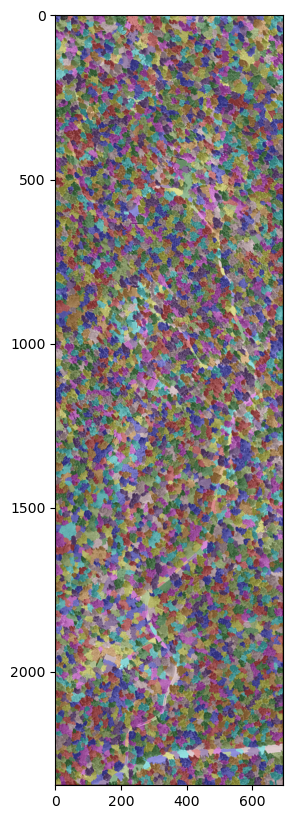

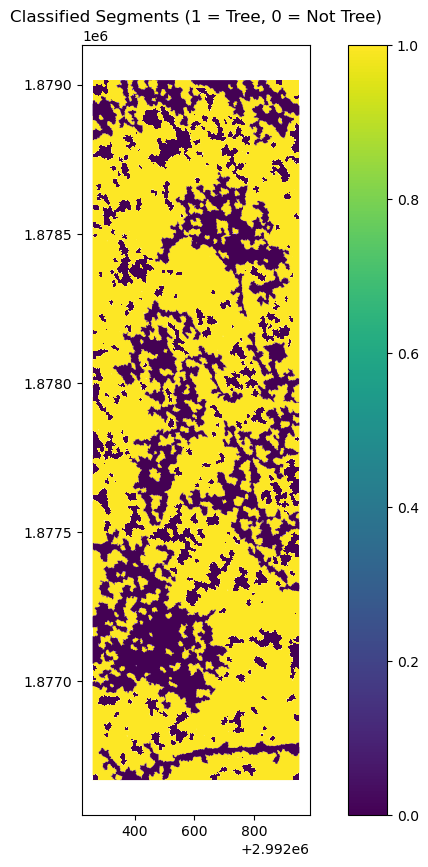

In [10]:
from skimage import io, color
from skimage.segmentation import quickshift, mark_boundaries
from rasterio.features import shapes
import numpy as np
import rasterio
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import matplotlib.pyplot as plt
from shapely.geometry import shape, Polygon
from shapely.ops import unary_union
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
from sklearn.cluster import KMeans

# Load the image and bands
tilepath = "../scratch/cropped_N4W351.tif"
tile = rasterio.open(tilepath)

red = tile.read(1).astype(float)
green = tile.read(2).astype(float)
blue = tile.read(3).astype(float)
nir = tile.read(4).astype(float)

# Get image bounding box info
sr = tile.crs
bounds = tile.bounds
affine = tile.transform

# Segment the image using quickshift
img = io.imread(tilepath)
img = img[:, :, :3]
segments = quickshift(img, kernel_size=3, convert2lab=False, max_dist=6, ratio=0.5).astype('int32')
print("Quickshift number of segments: %d" % len(np.unique(segments)))

# Convert segments to vector features
polys = []
for shp, value in shapes(segments, transform=affine):
    polys.append(shp)

# View the segments via Python
plt.figure(figsize=(10, 10))
plt.imshow(color.label2rgb(segments, img, bg_label=0))

# Compute mean values for each band in each segment
bands = np.stack([red, green, blue, nir], axis=-1)
mean_vals = []
for shp in polys:
    mask = rasterio.features.geometry_mask([shp], transform=affine, invert=True, out_shape=bands.shape[:2])
    mean_vals.append(bands[mask].mean(axis=0))

mean_vals = np.array(mean_vals)

# Apply k-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(mean_vals)
labels = kmeans.labels_

# Create GeoDataFrame with segments and their cluster labels
geom = [shape(i) for i in polys]
gdf = gpd.GeoDataFrame({'geometry': geom, 'cluster': labels}, crs=sr)

# Assuming cluster 0 is 'not tree' and cluster 1 is 'tree' (this can vary based on the data)
# You might need to inspect the characteristics of each cluster to determine which is which
# For example, assume higher mean NIR indicates trees, you can adjust based on your data
if mean_vals[labels == 0, 3].mean() > mean_vals[labels == 1, 3].mean():
    gdf['class'] = gdf['cluster']
else:
    gdf['class'] = 1 - gdf['cluster']

# Dissolve polygons by 'class' to merge connected polygons
dissolved_gdfs = []
for cls in gdf['class'].unique():
    class_gdf = gdf[gdf['class'] == cls]
    dissolved_gdf = class_gdf.dissolve()
    dissolved_gdf['class'] = cls
    dissolved_gdfs.append(dissolved_gdf)

# Combine the dissolved GeoDataFrames
dissolved_gdf = gpd.GeoDataFrame(pd.concat(dissolved_gdfs, ignore_index=True), crs=sr)

# Save the classified segments to a shapefile
dissolved_gdf.to_file('dissolved_classified_segments.shp')

# Plot the classified segments
fig, ax = plt.subplots(figsize=(10, 10))
dissolved_gdf.plot(column='class', ax=ax, legend=True, cmap='viridis')
plt.title("Classified Segments (1 = Tree, 0 = Not Tree)")
plt.show()

In [12]:
dissolved_gdf

,geometry,cluster,class
0,"MULTIPOLYGON (((2992277.000 1876674.000, 29922...",1,1
1,"MULTIPOLYGON (((2992274.000 1876683.000, 29922...",0,0


     class  area_feet  area_acres
0        1   928041.0   21.304890
1        1        2.0    0.000046
2        1     3826.0    0.087833
3        1        1.0    0.000023
4        1     7107.0    0.163154
..     ...        ...         ...
401      0        3.0    0.000069
402      0        1.0    0.000023
403      0      653.0    0.014991
404      0     1925.0    0.044192
405      0      169.0    0.003880

[406 rows x 3 columns]


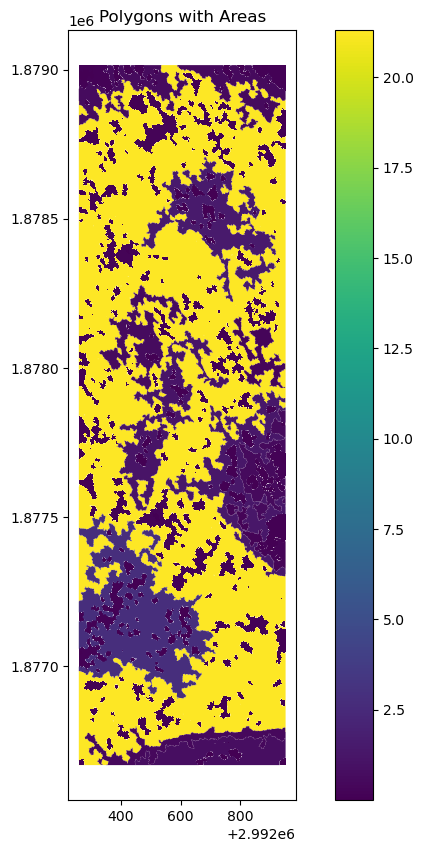

In [14]:
from shapely.geometry import Polygon, MultiPolygon

# Convert multipolygons to individual polygons
def multipolygons_to_polygons(dissolved_gdf):
    polygons = []
    classes = []
    for idx, row in dissolved_gdf.iterrows():
        if isinstance(row.geometry, MultiPolygon):
            for poly in row.geometry.geoms:  # Corrected line
                polygons.append(poly)
                classes.append(row['class'])
        else:
            polygons.append(row.geometry)
            classes.append(row['class'])
    return gpd.GeoDataFrame({'geometry': polygons, 'class': classes}, crs=dissolved_gdf.crs)

# Calculate area
def calculate_area(gdf):
    gdf['area_feet'] = gdf.geometry.area
    gdf['area_acres'] = gdf['area_feet'] / 43560
    return gdf

# Convert multipolygons to polygons
polygons_gdf = multipolygons_to_polygons(dissolved_gdf)

# Calculate areas
polygons_gdf = calculate_area(polygons_gdf)

# Output the areas
print(polygons_gdf[['class', 'area_feet', 'area_acres']])

# Plot the polygons with their areas
fig, ax = plt.subplots(figsize=(10, 10))
polygons_gdf.plot(column='area_acres', ax=ax, legend=True, cmap='viridis')
plt.title("Polygons with Areas")
plt.show()


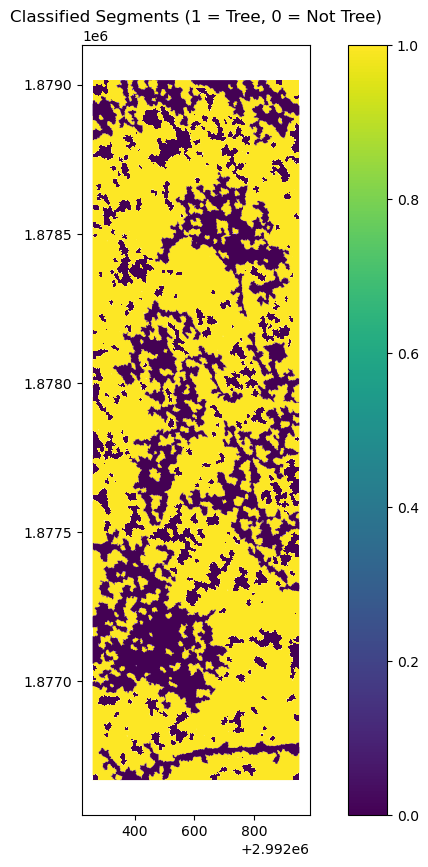

In [16]:
# Plot the classified segments
fig, ax = plt.subplots(figsize=(10, 10))
polygons_gdf.plot(column='class', ax=ax, legend=True, cmap='viridis')
plt.title("Classified Segments (1 = Tree, 0 = Not Tree)")
plt.show()

/Users/ed.chan/miniconda3/envs/treebeard/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


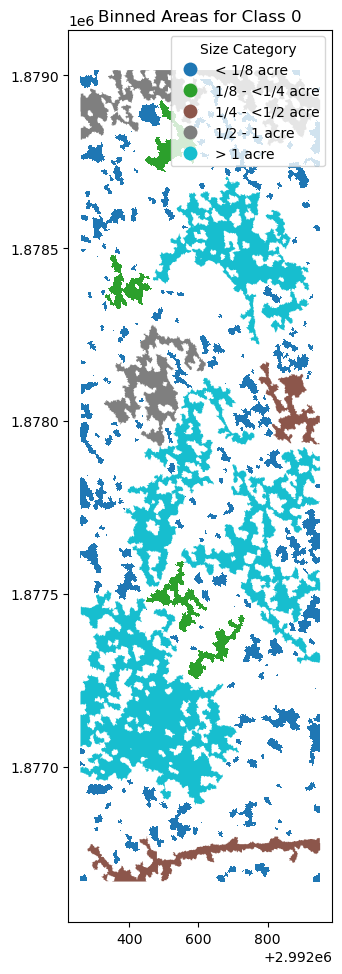

size_category
< 1/8 acre         276
1/8 - <1/4 acre      4
> 1 acre             4
1/2 - 1 acre         3
1/4 - <1/2 acre      2
Name: count, dtype: int64


In [17]:
import pandas as pd

# Function to bin and plot the areas
def bin_plot(gdf, bins, labels, title):
    gdf['size_category'] = pd.cut(gdf['area_acres'], bins=bins, labels=labels, right=False)
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plot = gdf.plot(column='size_category', ax=ax, legend=True, categorical=True, legend_kwds={'title': 'Size Category'})
    ax.set_title(title)
    plt.tight_layout()
    filename = title.split('.')[0]
    plt.savefig(f'{filename}.png')
    plt.show()

# Filter the GeoDataFrame for class = 0
class_0_gdf = polygons_gdf[polygons_gdf['class'] == 0]

# Define bins and labels
bins = [0, 1/8, 1/4, 1/2, 1, float('inf')]  # Added infinity to cover areas larger than 1 acre
labels = ['< 1/8 acre', '1/8 - <1/4 acre', '1/4 - <1/2 acre', '1/2 - 1 acre', '> 1 acre']

# Plot the binned areas
bin_plot(class_0_gdf, bins, labels, "Binned Areas for Class 0")

# Display binned area counts for validation
print(class_0_gdf['size_category'].value_counts())
